# CC6204 Deep Learning, Universidad de Chile
## Código de Red Neuronal "a mano"
El siguiente código muestra de manera tan directa como fue posible la forma de crear una red neuronal Feed Forward de dos capas escondidas usando solo las funcionalidades para operar tensores de pytorch (clases y funciones dentro del módulo [`torch`](http://pytorch.org/docs/master/torch.html#module-torch)) más las clases `torch.nn.Module` y `torc.nn.Parameter`.

La idea del código es mostrar cómo:

*   crear todos los parámetros de una red Feed Forward usando tensores,
*   computar la pasada hacia adelante de la red (predicción/forward) usando funciones sobre los mismos tensores y los datos de entrada por paquetes/batches (usando funciones de sigmoid y tangente hiperbólica como activación, y sigmoid final para el outpu),
*   computar la función de pérdida para la red (entropía cruzada en este caso),
*   calcular los gradientes desde la función de pérdida para todos los parámetros usando operadores sobre los tensores con el método de Back Propagation (backward),
*   actualizar los parámetros usando descenso de gradiente, y
*   reportar las métricas de predicción de la red sobre los datos.

Todos los pasos anteriores se repiten en un loop de entrenamiento por tantas iteraciones como se quiera (epochs). Otro punto muy importante es que gracias a pytorch y CoLaboratory, podemos realizar todas las pruebas de manera muy simple en una GPU. El código también sirve para explorar el impacto de realizar estos entrenamientos con hardware especializado.

Una de las gracias de usar pytorch es que nos permite hacer todo lo anterior a mano, paso a paso, sólo utilizando funciones básicas. Esto se podría también haber realizado utilizando sólo [NumPy](http://www.numpy.org/)  (es un buen ejercicio, hágalo!), pero no podríamos usar la GPU tan fácilmente como en pytorch.

El código está pensado para acompañar la clase de Back Propagation de CC6204 y servir como una introducción rápida a las funcionalidades básicas de pytorch. No está pensado en ser un código modular, si no más bien un código pedagógico para los temas de grafo de computación, back propagation, y descenso de gradiente por paquetes. Para entender el código requiere haber calculado antes derivadas de la función de pérdida (con lapiz y papel).

(Pensado para correr en [Colaboratory](http://colab.research.google.com))



Código por Jorge Pérez

https://github.com/jorgeperezrojas

[@perez](https://twitter.com/perez)

In [1]:
# Esto es solo para poder debugear.
# !pip install -q ipdb

import torch
import numpy as np
import sys
import time
# import ipdb

# Genera una semilla fija para que los experimentos sea repetibles.
t_cg = torch.manual_seed(1547)

In [2]:
# Función sigmoid, recibe un objeto torch.Tensor
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

# Función tanh, recibe un objeto torch.Tensor
def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

# Función de pérdida
def bi_cross_ent_loss(y_pred, y, safe=True, epsilon=1e-7):
  # tamaño del batch
  N = y.size()[0]

  if safe:
    # Asegura que no haya valores indefinidos.
    y_pred = y_pred.clamp(epsilon, 1-epsilon)

  B = (1-y) * torch.log(1-y_pred) + y * torch.log(y_pred)
  return -1/N * torch.sum(B)

In [3]:
# Las redes en pytorch deben heredar desde torch.nn.Module
class FFNN(torch.nn.Module):
  def __init__(self, d0=300, d1=200, d2=300, init_v=1):
    super(FFNN, self).__init__()

    # Crea los tensores como parámetros
    self.W1 = torch.nn.Parameter(torch.randn(d0,d1) * init_v)
    self.b1 = torch.nn.Parameter(torch.zeros(d1))
    self.W2 = torch.nn.Parameter(torch.randn(d1,d2) * init_v)
    self.b2 = torch.nn.Parameter(torch.zeros(d2))
    self.U = torch.nn.Parameter(torch.randn(d2,1) * init_v)
    self.c = torch.nn.Parameter(torch.zeros(1))

  # Computa la pasada hacia adelante
  def forward(self, x):

    u1 = x @ self.W1 + self.b1
    h1 = tanh(u1)
    u2 = h1 @ self.W2 + self.b2
    h2 = sig(u2)
    u3 = h2 @ self.U + self.c
    y_pred = sig(u3)

    self._cache = [u1, u2] # podemos usar un mejor cache?

    return y_pred

  # Backpropagation
  def backward(self, x, y, y_pred):
    # recuperamos el "cache"
    u1, u2 = self._cache # podemos usar un mejor cache?

    # tamaño del batch
    b = x.size()[0]

    # Estas son derivadas calculadas a mano
    dL_du3 = (1/b) * (y_pred - y)
    dL_dU  = sig(u2).t() @ dL_du3
    dL_dc  = torch.sum(dL_du3, 0)
    dL_dh2 = dL_du3 @ self.U.t()
    dL_du2 = dL_dh2 * sig(u2) * (1 - sig(u2))
    dL_dW2 = tanh(u1).t() @ dL_du2
    dL_db2 = torch.sum(dL_du2, 0)
    dL_dh1 = dL_du2 @ self.W2.t()
    dL_du1 = dL_dh1 * (1 - tanh(u1) * tanh(u1))
    dL_dW1 = x.t() @ dL_du1
    dL_db1 = torch.sum(dL_du1,0)

    # Registra los valores de gradientes en cada tensor (que nos interesa)
    grads = [dL_dW1, dL_db1, dL_dW2, dL_db2, dL_dU, dL_dc]
    params = [self.W1, self.b1, self.W2, self.b2, self.U, self.c]
    for p, g in zip(params, grads):
      p.grad = g

  def num_parameters(self):
    total = 0
    for p in self.parameters():
      total += p.numel()
    return total

In [4]:
from torch.utils.data import Dataset, DataLoader

class RandomDataSet(Dataset):
  def __init__(self, N, f):
    R_N_f = torch.rand(N,f)
    self.X = torch.bernoulli(R_N_f)
    R_N_1 = torch.rand(N,1)
    self.Y = torch.bernoulli(R_N_1)
    self.num_features = f

  # Debemos definir __len__ para retornar el tamaño del dataset
  def __len__(self):
    return self.X.size()[0]

  # Debemos definir __getitem__ para retornar el i-ésimo
  # ejemplo en nuestro dataset.
  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [ ]:
def loop_FFNN_with_logs(dataset, batch_size, d1, d2, lr,
                        epochs, run_in_GPU=True, reports_every=1,
                        init_v=1):
    # Tipo para los tensores según si se usa GPU
    device = 'cuda' if run_in_GPU else 'cpu'

    # d0 es la cantidad de features
    d0 = dataset.num_features

    # Crear la red y enviarla al dispositivo
    red = FFNN(d0, d1, d2, init_v).to(device)

    # Mostrar la cantidad de parámetros
    print('Cantidad de parámetros:', red.num_parameters())

    # Crea un dataloader desde el dataset
    data = DataLoader(dataset, batch_size, shuffle=True)

    # Listas para almacenar métricas
    loss_history = []
    accuracy_history = []

    tiempo_epochs = 0
    for e in range(1, epochs + 1):
        inicio_epoch = time.time()

        for (x, y) in data:
            # Asegura que estén en GPU si es necesario
            x, y = x.to(device), y.to(device)

            # Forward pass
            y_pred = red.forward(x)

            # Loss
            L = bi_cross_ent_loss(y_pred, y)

            # Backpropagation
            red.backward(x, y, y_pred)

            # Descenso de gradiente
            for p in red.parameters():
                p.data -= lr * p.grad

        tiempo_epochs += time.time() - inicio_epoch

        # Cálculo y reporte cada "reports_every" épocas
        if e % reports_every == 0:
            X = dataset.X.to(device)
            Y = dataset.Y.to(device)

            # Predicciones
            Y_PRED = red.forward(X)

            # Loss en todo el conjunto
            L_total = bi_cross_ent_loss(Y_PRED, Y).item()

            # Predicciones binarias
            Y_PRED_BIN = (Y_PRED >= 0.5).float()
            correctos = torch.sum(Y_PRED_BIN == Y).item()
            acc = (correctos / len(dataset)) * 100

            # Almacenar métricas
            loss_history.append(L_total)
            accuracy_history.append(acc)

            # Mostrar progreso
            sys.stdout.write(
                '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(acc)
                + ' Loss:{0:.4f}'.format(L_total)
                + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs / e)
            )

    return loss_history, accuracy_history

In [13]:
N = 5000 # numero de ejemplos
f = 300 # numero de features

dataset = RandomDataSet(N,f)

In [14]:
epochs = 20
loss_history, accuracy_history = loop_FFNN_with_logs(
    dataset=dataset, batch_size=10, d1=300, d2=400, epochs=epochs,
    run_in_GPU=True, lr=0.06, init_v=1
)

Cantidad de parámetros: 211101
Epoch:020 Acc:100.00% Loss:0.0156 Tiempo/epoch:0.523s

Para ejemplificar, probar el anterior código de la siguiente forma:

*   Cambiar el tamaño del batch desde 2 a 1000: visualizar tiempo de entrenamiento vs Acc
*   Cambiar el tamaño de las capas / número de parámetros (llegar a 1000/2000) y visualizar tiempo de entrenamiento (qué pasa si entrenas en la CPU en vez de la GPU?)
*   Cambiar el valor máximo de inicialización (0.01,1,1.5,2)
*   Mostrar que se pueden calcular (aun) más eficiente la pasada hacia atrás reutilizando algunos valores previamente computados cuando derivamos `sig` y `tanh`: visualizar el tiempo de entrenamiento.
*   Mostrar como `.backward()` puede hacer todo el trabajo de backpropagation por nosotros. Ojo con anular los gradientes con `.zero_()` y mantener la red de tamaño razonable por la estabilidad numérica (200/300 tamaño parece bien)


In [15]:
# Función para graficar
import matplotlib.pyplot as plt

def plot_metrics(loss_history, accuracy_history):
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, label='Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


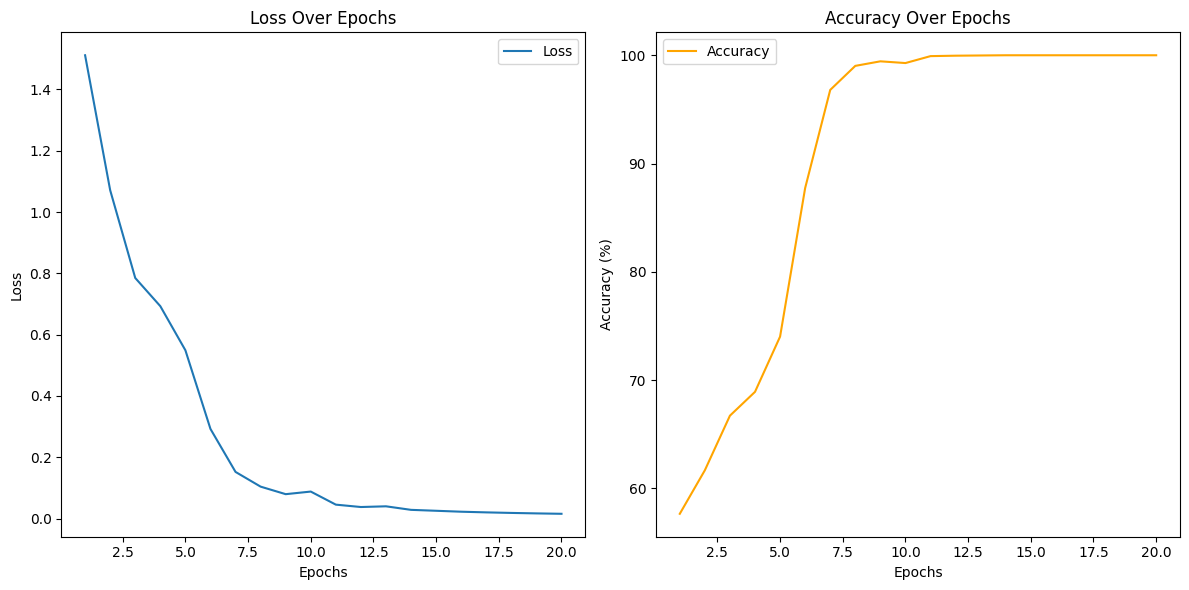

In [16]:
plot_metrics(loss_history, accuracy_history)   